In [2]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
cancer = load_breast_cancer()

In [6]:
data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(2)

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38           122.8     1001.0          0.11840   
1        20.57         17.77           132.9     1326.0          0.08474   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   

   mean fractal dimension  ...  worst radius  worst texture  worst perimeter  \
0                 0.07871  ...         25.38          17.33            184.6   
1                 0.05667  ...         24.99          23.41            158.8   

   worst area  worst smoothness  worst compactness  worst concavity  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   

   worst concave points  worst symmetry  worst fractal dimension  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  

[2 rows x 30 columns]

In [8]:
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

vo_clf = VotingClassifier(estimators=[('LR', lr_clf),('KNN', knn_clf)],
                          voting='soft')

x_train, x_test, y_train, y_test = train_test_split(data_df,
                                                    cancer.target,
                                                    test_size=0.2,
                                                    random_state=156)
vo_clf.fit(x_train, y_train)
pred = vo_clf.predict(x_test)
accuracy_score(y_test, pred)

0.956140350877193

In [13]:
lr_clf.fit(x_train, y_train)
pred_l = lr_clf.predict(x_test)

knn_clf.fit(x_train, y_train)
pred_k = knn_clf.predict(x_test)

accuracy_score(y_test, pred_l), accuracy_score(y_test, pred_k)

(0.9473684210526315, 0.9385964912280702)

In [17]:
from sklearn.ensemble import RandomForestClassifier

def get_new_feature_name_df(old) :
    df = pd.DataFrame(data=old.groupby('column_name').cumcount(),
                    columns=['dup_cnt'])
    df = df.reset_index()
    new_df = pd.merge(old.reset_index(), df, how='outer')
    new_df['column_name'] = new_df[['column_name', 'dup_cnt']].apply(lambda x: x[0] + '_' + str(x[1]) 
                                                                    if x[1] > 0 
                                                                    else x[0] , axis=1)
    new_df.drop(columns=['index'], inplace=True)
    return new_df
def get_human_dataset():
    feature_name_df =  pd.read_csv('./human_activity/features.txt',
                                sep='\s+',
                                header=None,
                                names=['column_index', 'column_name'])
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    x_train = pd.read_csv('./human_activity/train/X_train.txt',
                          sep='\s+',
                          names= feature_name)
    x_test = pd.read_csv('./human_activity/test/X_test.txt',
                          sep='\s+',
                          names= feature_name)
    y_train = pd.read_csv('./human_activity/train/y_train.txt',
                          sep='\s+', names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',
                          sep='\s+', names=['action'])
    return x_train, x_test, y_train, y_test

In [20]:
x_train, x_test, y_train, y_test = get_human_dataset()

In [21]:
rf_clf = RandomForestClassifier(random_state=0, n_estimators=500)
rf_clf.fit(x_train, y_train)
pred = rf_clf.predict(x_test)
accuracy_score(y_test, pred)

C:\Users\admin\AppData\Local\Temp\ipykernel_20676\2504107462.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(x_train, y_train)


0.9284017645062775

In [26]:
from sklearn.model_selection import GridSearchCV

param = {
    'n_estimators': [100],
    'max_depth': [6,8,10,12],
    'min_samples_split': [8, 16, 20]
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=1)
grid_cv = GridSearchCV(rf_clf, param_grid=param, cv=2, n_jobs=-1)
grid_cv.fit(x_train, y_train)

print(f'최적의 하이퍼 파라메터: {grid_cv.best_params_}')
print(f'최고의 예측 정확도 : {grid_cv.best_score_:.4f}')


c:\Users\admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


최적의 하이퍼 파라메터: {'max_depth': 6, 'min_samples_split': 8, 'n_estimators': 100}
최고의 예측 정확도 : 0.9124


In [28]:
rf_clf = RandomForestClassifier(random_state=0,
                                n_jobs=-1,
                                n_estimators=100,
                                max_depth=10,
                                min_samples_leaf=8,
                                min_samples_split=8)
rf_clf.fit(x_train, y_train)
pred = rf_clf.predict(x_test)
accuracy_score(y_test, pred)

C:\Users\admin\AppData\Local\Temp\ipykernel_20676\3720053160.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(x_train, y_train)


0.9195792331184255

In [30]:
import numpy as np
np.round(rf_clf.feature_importances_,2)

array([0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.03, 0.03, 0.01, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.02, 0.01, 0.03, 0.02, 0.01,
       0.  , 0.03, 0.02, 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01,
       0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ,
       0.01, 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

<Axes: >

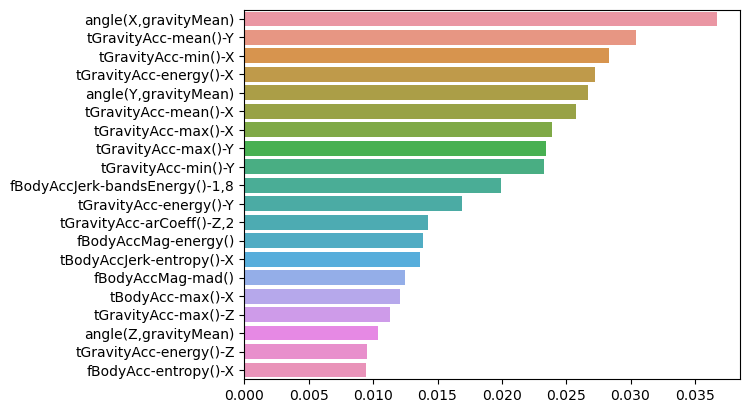

In [38]:
import seaborn as sns
rf_clf_1 = rf_clf.feature_importances_

rf_clf_df = pd.Series(rf_clf_1, index=x_train.columns)
top20 = rf_clf_df.sort_values(ascending=False)[:20]
sns.barplot(x=top20, y=top20.index)

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

In [40]:
%%time
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(x_train, y_train)
pred = gb_clf.predict(x_test)
accuracy_score(y_test, pred)

c:\Users\admin\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: total: 11min 39s
Wall time: 11min 46s


0.9389209365456397

In [41]:
from sklearn.model_selection import GridSearchCV

param = {
    'n_estimators' : [100, 500],
    'learning_rate' : [0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf, param_grid= param, cv=2, verbose=1)
grid_cv.fit(x_train, y_train)
print('최적의 하이퍼 파라미터 : ', grid_cv.best_params_)
print('최고 예측 정확도 : ', grid_cv.best_score_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


c:\Users\admin\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\admin\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\admin\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
